In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import seaborn as sns
import torch
from tqdm.notebook import tqdm

In [3]:
import sys
sys.path.append('../src')

In [4]:
from common.nb_utils import estimate_optimal_ncomponents, pca_transform

In [5]:
def projection(v1, v2):
    return torch.abs(
        (v1*v2).sum()/(v2*v2).sum()
    ).item()

def momentum_grad(prev_v, grad, momentum):
    return momentum * prev_v + grad

In [6]:
# hist_file = '../ckpts/mnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/mnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'

# hist_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'

hist_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.1_decay_1e-05_batch_60000.pkl'
meta_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.1_decay_1e-05_batch_60000_processed_grads.pkl'

# hist_file = '../ckpts/fmnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/fmnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'


In [ ]:
h = pkl.load(open(hist_file, 'rb'))
meta = pkl.load(open(meta_file, 'rb'))

In [8]:
mat_99 = meta['mat_99']
mat_95 = meta['mat_95']
overlap = meta['overlap_99']
overlap_self = meta['overlap_self']
l_params = meta['num_params']
num_layers = len(l_params)

In [9]:
epoch, train_acc, test_acc, train_loss, test_loss, grads = h

# inter-grad overlap w/ momentum

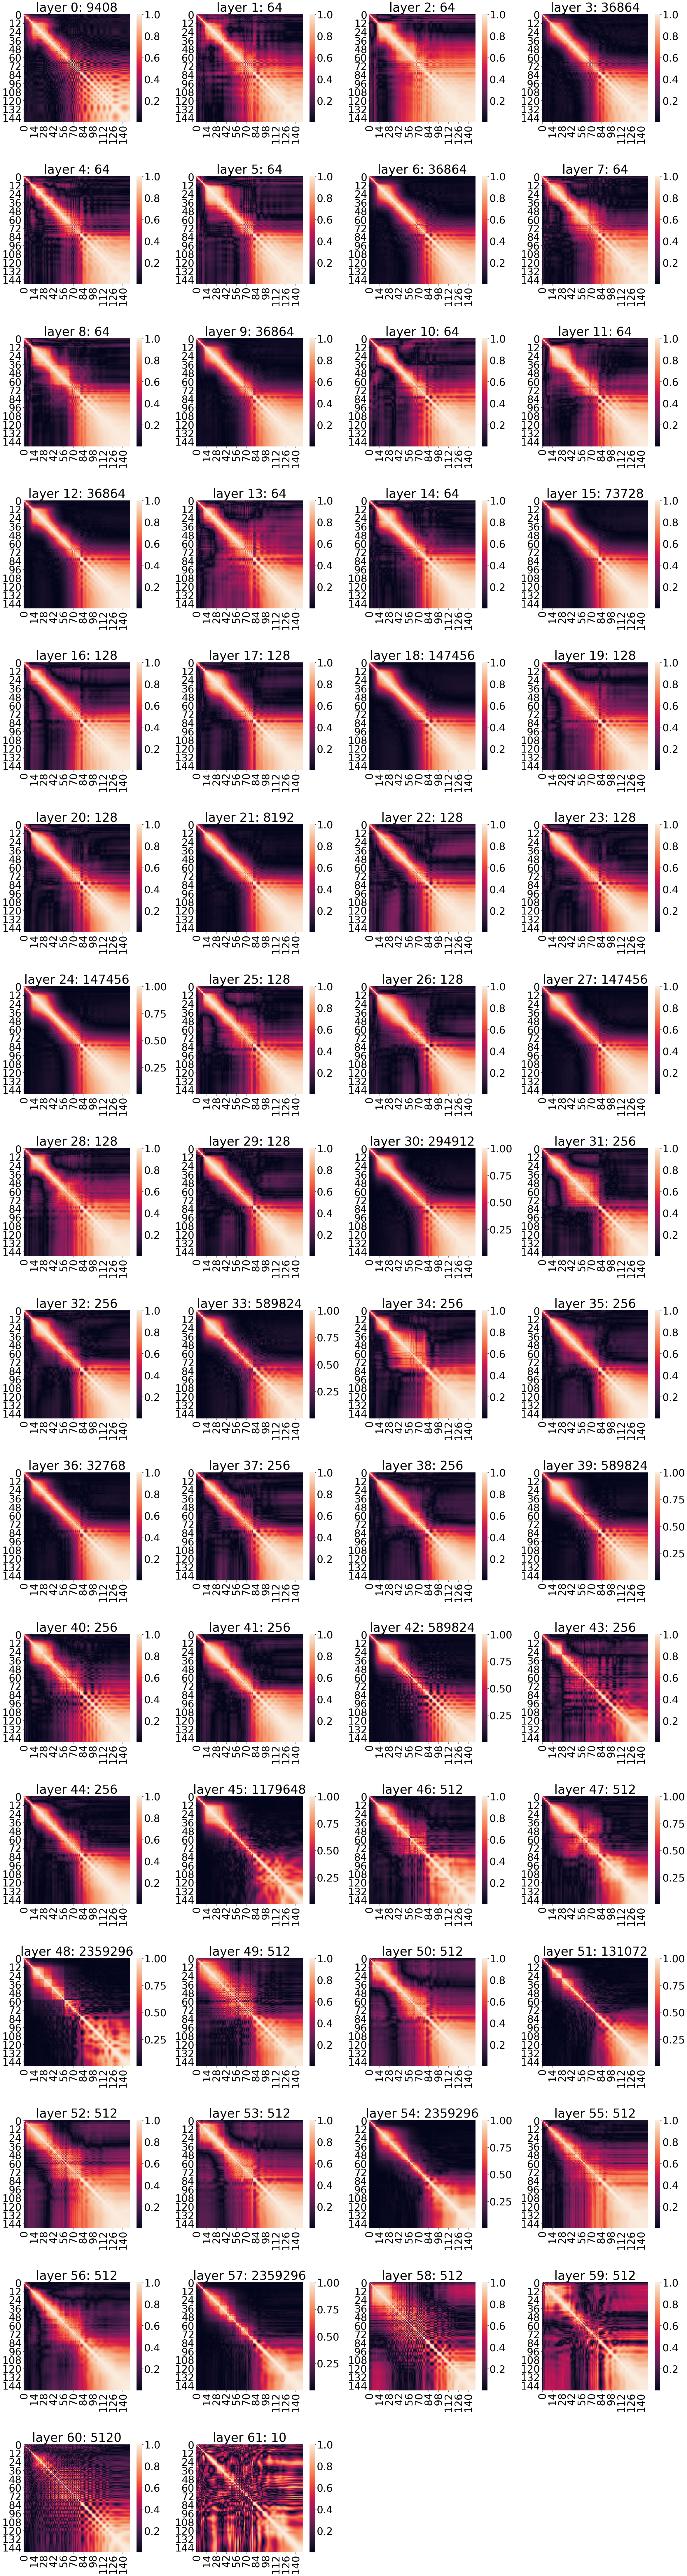

In [10]:
matplotlib.rcParams.update({'font.size': 35})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

cols = 4
rows = num_layers//cols
if num_layers%cols:
    rows += 1
fig = plt.figure(figsize=(10*cols, 10*rows))

prev_v = [torch.zeros_like(grads[0][_]) for _ in range(len(grads[0]))]
momentum = 0.9

for layer_num, olap in enumerate(overlap_self):
    ax = fig.add_subplot(rows, cols, layer_num+1)
    sns.heatmap(np.abs(olap), ax=ax)
    ax.set_title('layer {}: {}'.format(layer_num, l_params[layer_num]))
    
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# pca-grad overlap w/ momentum

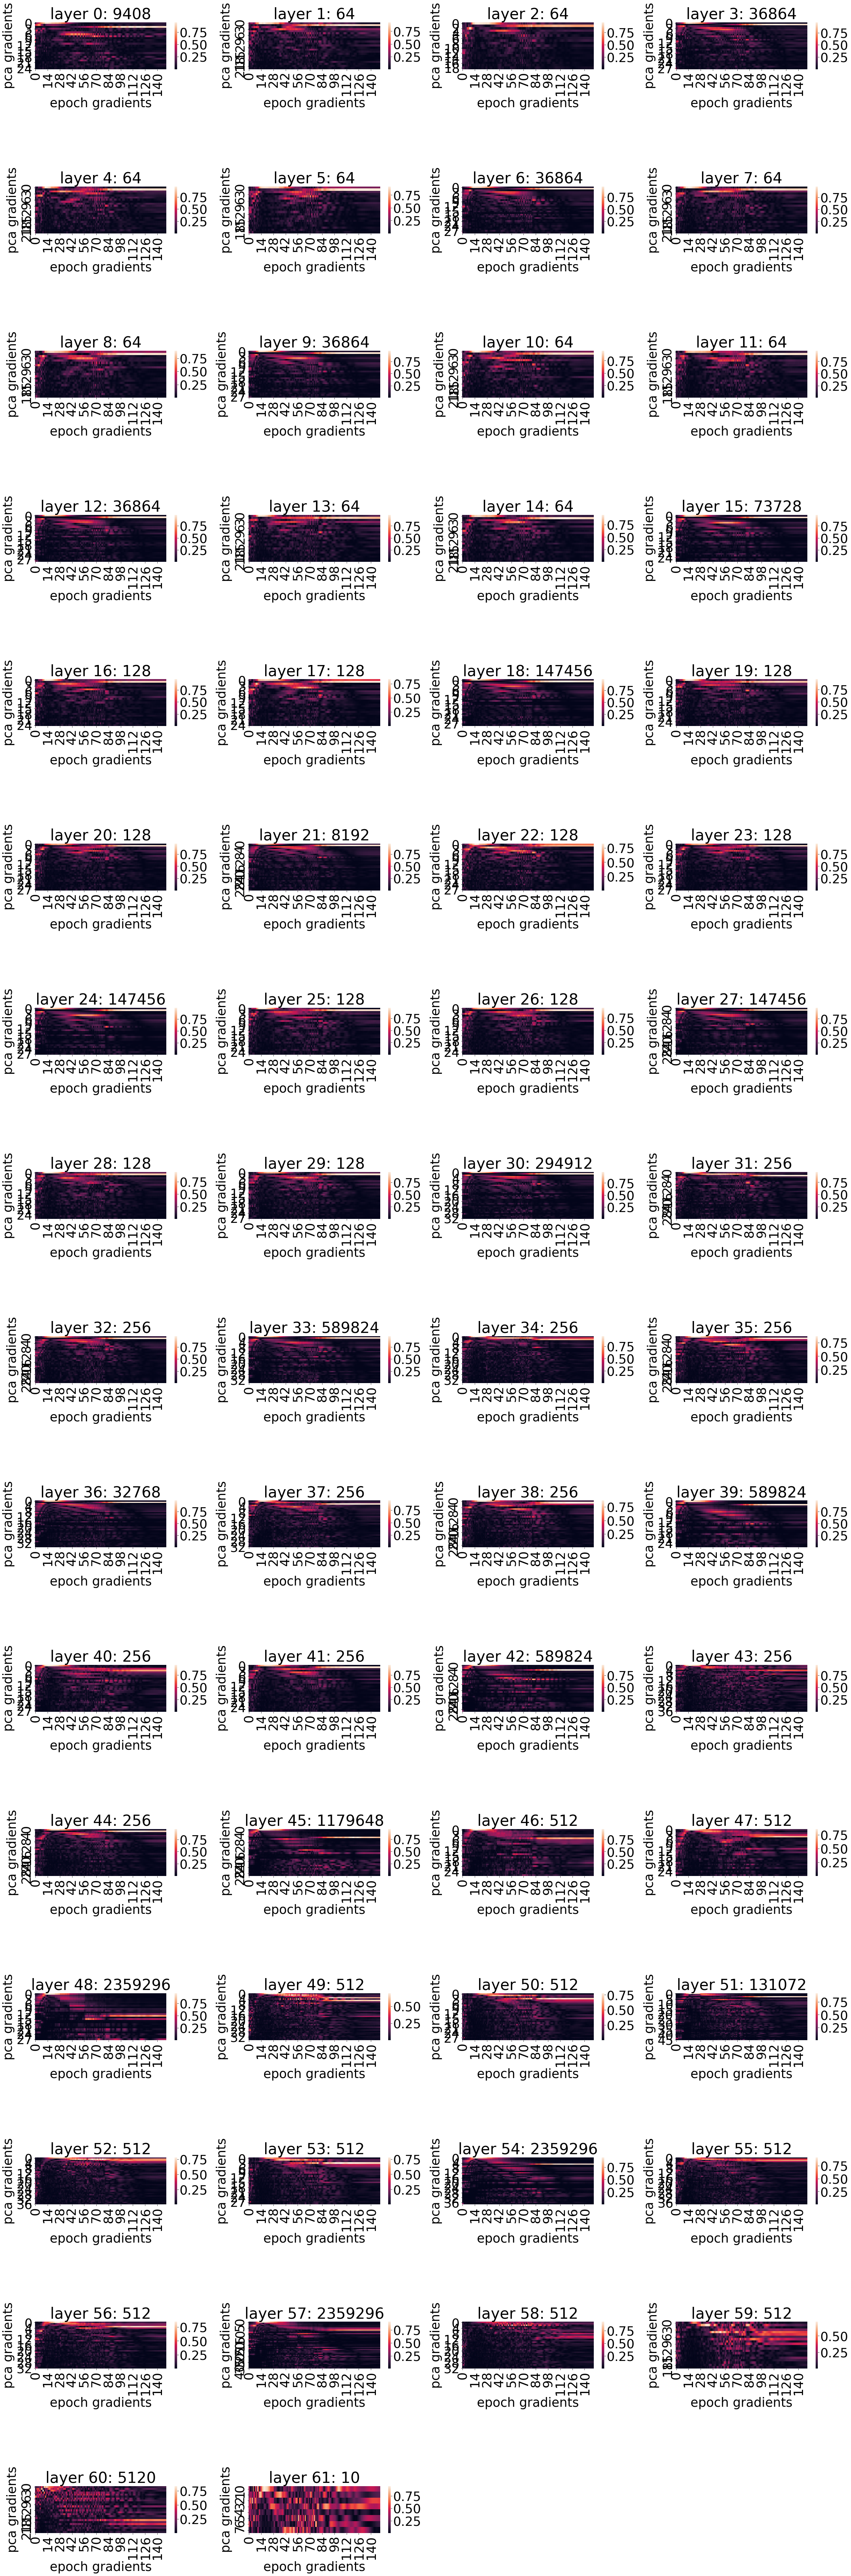

In [16]:
matplotlib.rcParams.update({'font.size': 35})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

fig = plt.figure(figsize=(10*4, 8*16))
for idx, olap in tqdm(enumerate(overlap), total=len(overlap)):
    ax = fig.add_subplot(16, 4, idx+1)
    sns.heatmap(np.abs(olap), ax=ax)
    ax.set_xlabel('epoch gradients')
    ax.set_ylabel('pca gradients')
    ax.set_title('layer {}: {}'.format(idx, l_params[idx]))
plt.subplots_adjust(hspace=2.5, wspace=0.3)
plt.show()

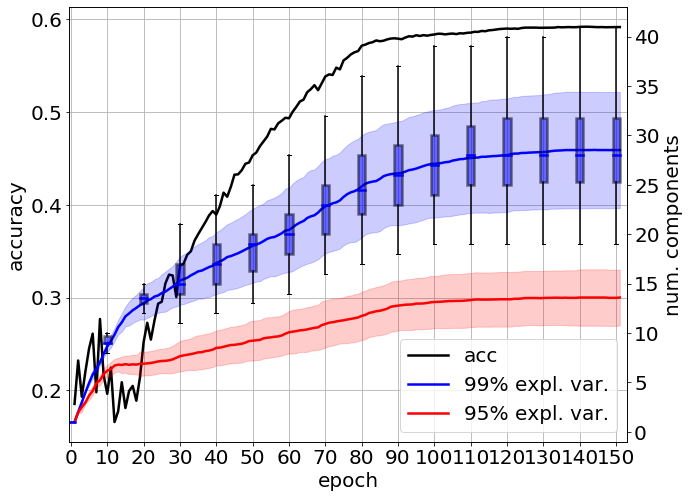

In [13]:
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ln1 = ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

mu_99 = mat_99.mean(axis=1)
std_99 = mat_99.std(axis=1)
boxprops = dict(facecolor="b", color='k', alpha=0.5, linewidth=2.5)
medianprops = dict(color="b",linewidth=2.5)
whiskerprops = dict(color="k",linewidth=1.5)

ax2.boxplot([mat_99[i] for i in range(0, mat_99.shape[0], 10)], 
            positions=list(range(0, mat_99.shape[0], 10)), widths=[2.0]*16, 
            showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
ln2 = ax2.plot(epoch, mu_99, color='b', label='99% expl. var.')
ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, color='b', alpha=0.2)

mu_95 = mat_95.mean(axis=1)
std_95 = mat_95.std(axis=1)
ln3 = ax2.plot(epoch, mu_95, color='r', label='95% expl. var.')
ax2.fill_between(epoch, mu_95-std_95, mu_95+std_95, color='r', alpha=0.2)
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('num. components')
plt.xlim(left=-0.5, right=mat_99.shape[0]+2)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
plt.show()

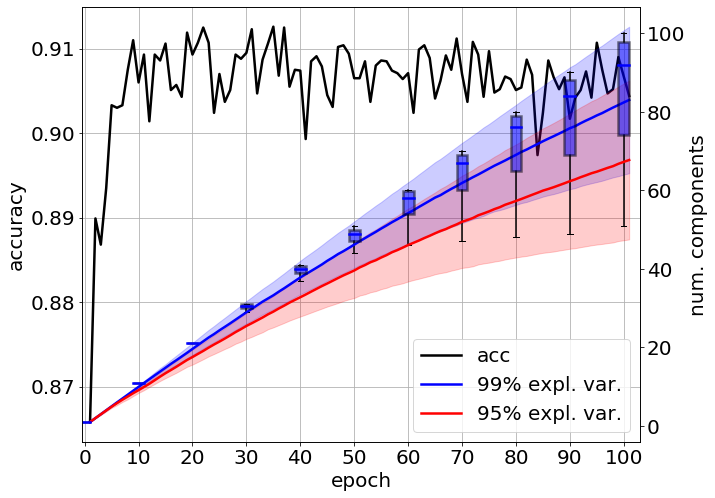

In [13]:
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ln1 = ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

mu_99 = mat_99.mean(axis=1)
std_99 = mat_99.std(axis=1)
boxprops = dict(facecolor="b", color='k', alpha=0.5, linewidth=2.5)
medianprops = dict(color="b",linewidth=2.5)
whiskerprops = dict(color="k",linewidth=1.5)

ax2.boxplot([mat_99[i] for i in range(0, mat_99.shape[0], 10)], 
            positions=list(range(0, mat_99.shape[0], 10)), widths=[2.0]*11, 
            showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
ln2 = ax2.plot(epoch, mu_99, color='b', label='99% expl. var.')
ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, color='b', alpha=0.2)

mu_95 = mat_95.mean(axis=1)
std_95 = mat_95.std(axis=1)
ln3 = ax2.plot(epoch, mu_95, color='r', label='95% expl. var.')
ax2.fill_between(epoch, mu_95-std_95, mu_95+std_95, color='r', alpha=0.2)
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('num. components')
plt.xlim(left=-0.5, right=mat_99.shape[0]+2)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
plt.show()

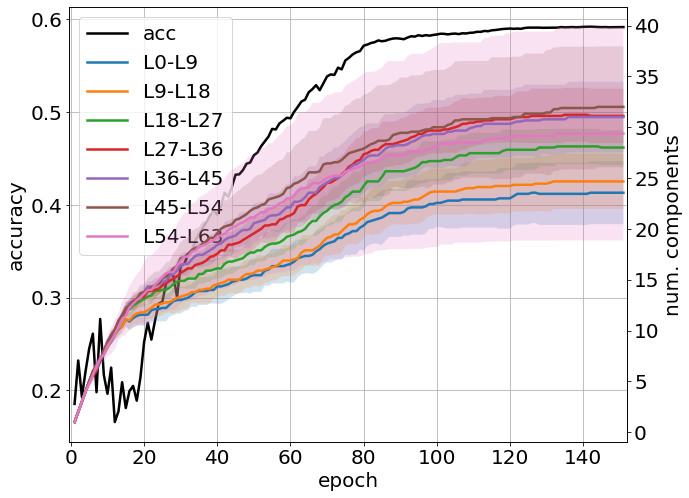

In [17]:
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

intv = 9
for j in range(0, mat_99.shape[1], intv):
    mu_99 = mat_99[:, j:j+intv].mean(axis=1)
    std_99 = mat_99[:, j:j+intv].std(axis=1)
    lns += ax2.plot(epoch, mu_99, label='L{}-L{}'.format(j, j+intv))
    ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, alpha=0.2)

# ax2.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('num. components')

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)
ax1.grid()
plt.xlim(left=-0.5, right=mat_99.shape[0]+1)
plt.show()

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

mu_99 = mat_99.mean(axis=1)
std_99 = mat_99.std(axis=1)
ax2.plot(epoch, mu_99, color='b', label='99% expl. var.')
ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, color='b', alpha=0.2)

mu_95 = mat_95.mean(axis=1)
std_95 = mat_95.std(axis=1)
ax2.plot(epoch, mu_95, color='r', label='95% expl. var.')
ax2.fill_between(epoch, mu_95-std_95, mu_95+std_95, color='r', alpha=0.2)
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
# ax2.set_ylabel('num. components')
plt.show()